In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA

from tqdm import tqdm

import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('ggplot')

# Read and prepare Data first

In [3]:
SIG = pandas.read_csv('data/signal.csv', sep=';')
BKG = pandas.read_csv('data/background.csv', sep=';')

In [4]:
def remove_constant_columns(df):
    data = df.loc[:, (df != df.ix[0]).any()]
    return data

In [5]:
def combine_data(sig, bkg):
    ind = sig.columns.isin(bkg.columns)
    column_ind = sig.columns[ind]
    data = sig[column_ind].append(bkg[column_ind], ignore_index=True)
    labels = np.append(np.ones(sig.shape[0]), np.zeros(bkg.shape[0]))
    return data, labels

In [6]:
SIG = remove_constant_columns(SIG)
BKG = remove_constant_columns(BKG)

In [7]:
DATA, LABELS = combine_data(SIG, BKG)
DATA = DATA.dropna(axis=1)

Drop some very distinguishing features, it seems like everything containing `MC` is heavily correlated with the labels

In [8]:
DATA.filter(regex='MC|Weight|EventHeader|ID|HitStat').columns

Index(['CorsikaWeightMap.Atmosphere', 'CorsikaWeightMap.Multiplicity',
       'CorsikaWeightMap.TimeScale', 'HitStatisticsValues.cog_z_sigma',
       'HitStatisticsValues.min_pulse_time',
       'HitStatisticsValues.max_pulse_time', 'HitStatisticsValues.q_max_doms',
       'HitStatisticsValues.z_min', 'HitStatisticsValues.z_max',
       'HitStatisticsValues.z_mean', 'HitStatisticsValues.z_sigma',
       'HitStatisticsValues.z_travel', 'HitStatisticsValues.cog_x',
       'HitStatisticsValues.cog_y', 'HitStatisticsValues.cog_z',
       'I3EventHeader.Run', 'I3EventHeader.Event', 'I3EventHeader.SubEvent',
       'I3EventHeader.time_start_utc_daq', 'I3EventHeader.time_start_mjd_ns',
       'I3EventHeader.time_end_utc_daq', 'I3EventHeader.time_end_mjd_ns',
       'MCECenter.value', 'MCMostEnergeticInIce.x', 'MCMostEnergeticInIce.y',
       'MCMostEnergeticInIce.z', 'MCMostEnergeticInIce.time',
       'MCMostEnergeticInIce.zenith', 'MCMostEnergeticInIce.azimuth',
       'MCMostEnergeticInIce

In [9]:
DATA.drop(DATA.filter(regex='MC|Weight|EventHeader|ID').columns, axis=1, inplace=True);

In [10]:
list(DATA.columns)

['HitMultiplicityValues.n_hit_strings',
 'HitMultiplicityValues.n_hit_doms',
 'HitMultiplicityValues.n_hit_doms_one_pulse',
 'HitStatisticsValues.cog_z_sigma',
 'HitStatisticsValues.min_pulse_time',
 'HitStatisticsValues.max_pulse_time',
 'HitStatisticsValues.q_max_doms',
 'HitStatisticsValues.z_min',
 'HitStatisticsValues.z_max',
 'HitStatisticsValues.z_mean',
 'HitStatisticsValues.z_sigma',
 'HitStatisticsValues.z_travel',
 'HitStatisticsValues.cog_x',
 'HitStatisticsValues.cog_y',
 'HitStatisticsValues.cog_z',
 'LineFit_TT.x',
 'LineFit_TT.y',
 'LineFit_TT.z',
 'LineFit_TT.time',
 'LineFit_TT.zenith',
 'LineFit_TT.azimuth',
 'LineFit_TTParams.lf_vel',
 'LineFit_TTParams.lf_vel_x',
 'LineFit_TTParams.lf_vel_y',
 'LineFit_TTParams.lf_vel_z',
 'LineFit_TTParams.n_hits',
 'MPEFitHighNoise.x',
 'MPEFitHighNoise.y',
 'MPEFitHighNoise.z',
 'MPEFitHighNoise.time',
 'MPEFitHighNoise.zenith',
 'MPEFitHighNoise.azimuth',
 'MPEFitParaboloid.x',
 'MPEFitParaboloid.y',
 'MPEFitParaboloid.z',
 'MP

100%|██████████| 125/125 [00:23<00:00,  6.00it/s]


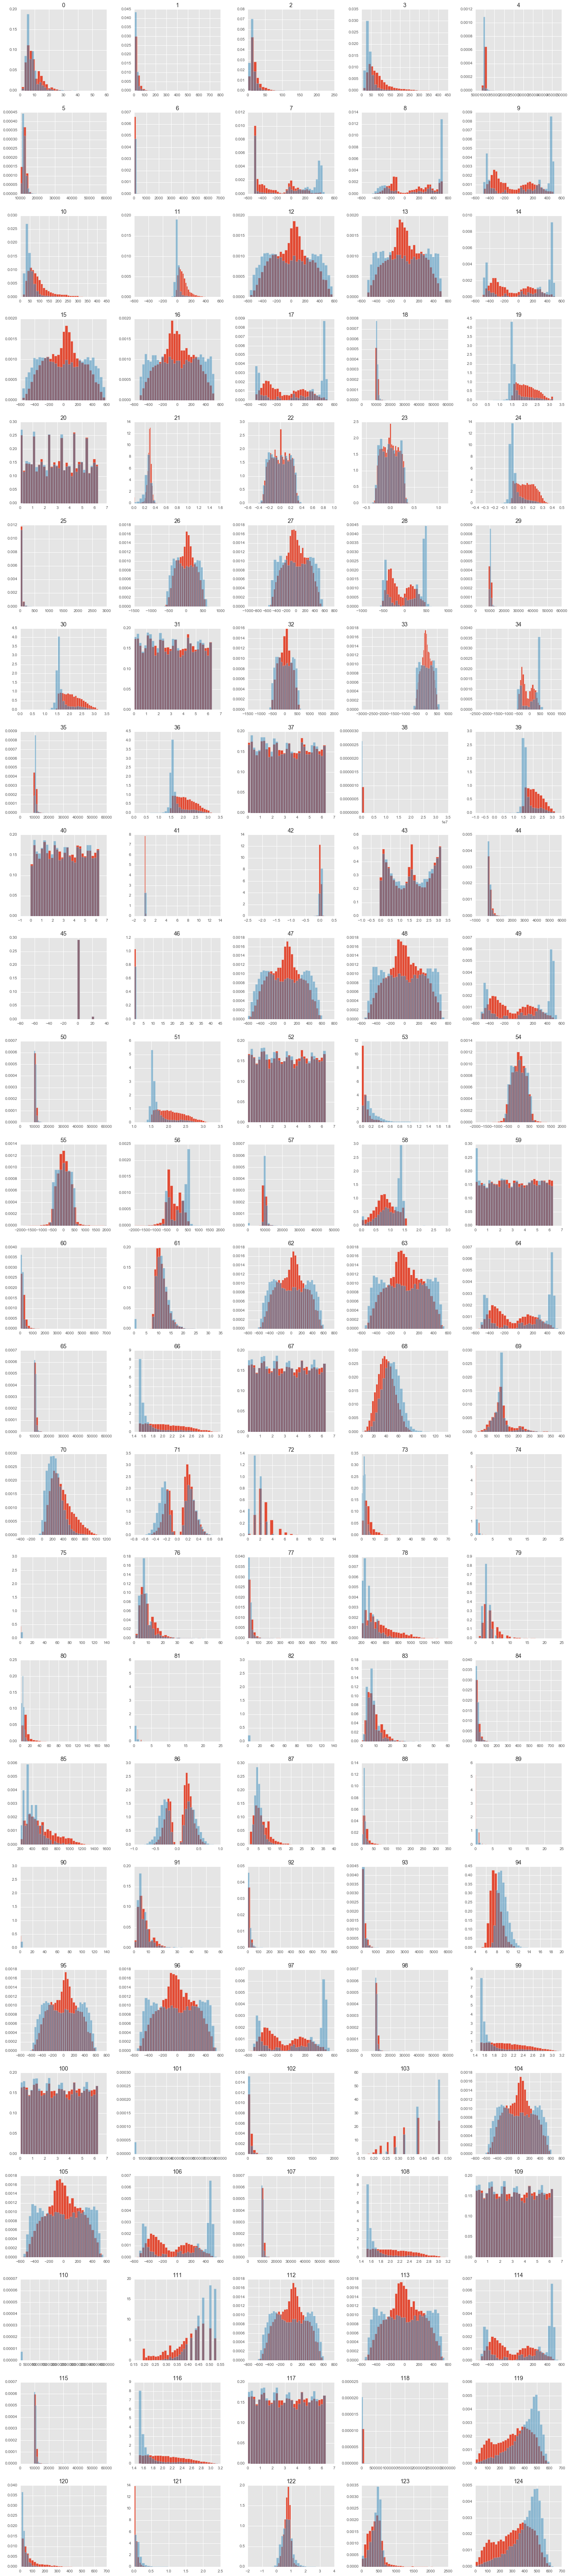

In [11]:
# Plot features, we have 157 of them this will probably take a while
plt.figure(figsize=(20, 90))
for i, feature in tqdm(enumerate(DATA.columns), total=len(DATA.columns)):
    plt.subplot(np.ceil(len(DATA.columns) / 5), 5, i+1)
    _, bins, _ = plt.hist(DATA[LABELS==1][feature], bins=31, normed=True)
    plt.hist(DATA[LABELS==0][feature], bins=31, alpha=0.5, normed=True)
    plt.title(i)
plt.tight_layout()
plt.show()

In [12]:
gb = GradientBoostingClassifier()

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(DATA, LABELS, test_size=0.3)
gb.fit(train_data, train_labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [14]:
proba = gb.predict_proba(test_data)[:,1]
score = roc_auc_score(test_labels, proba)
score

0.99406544785724349

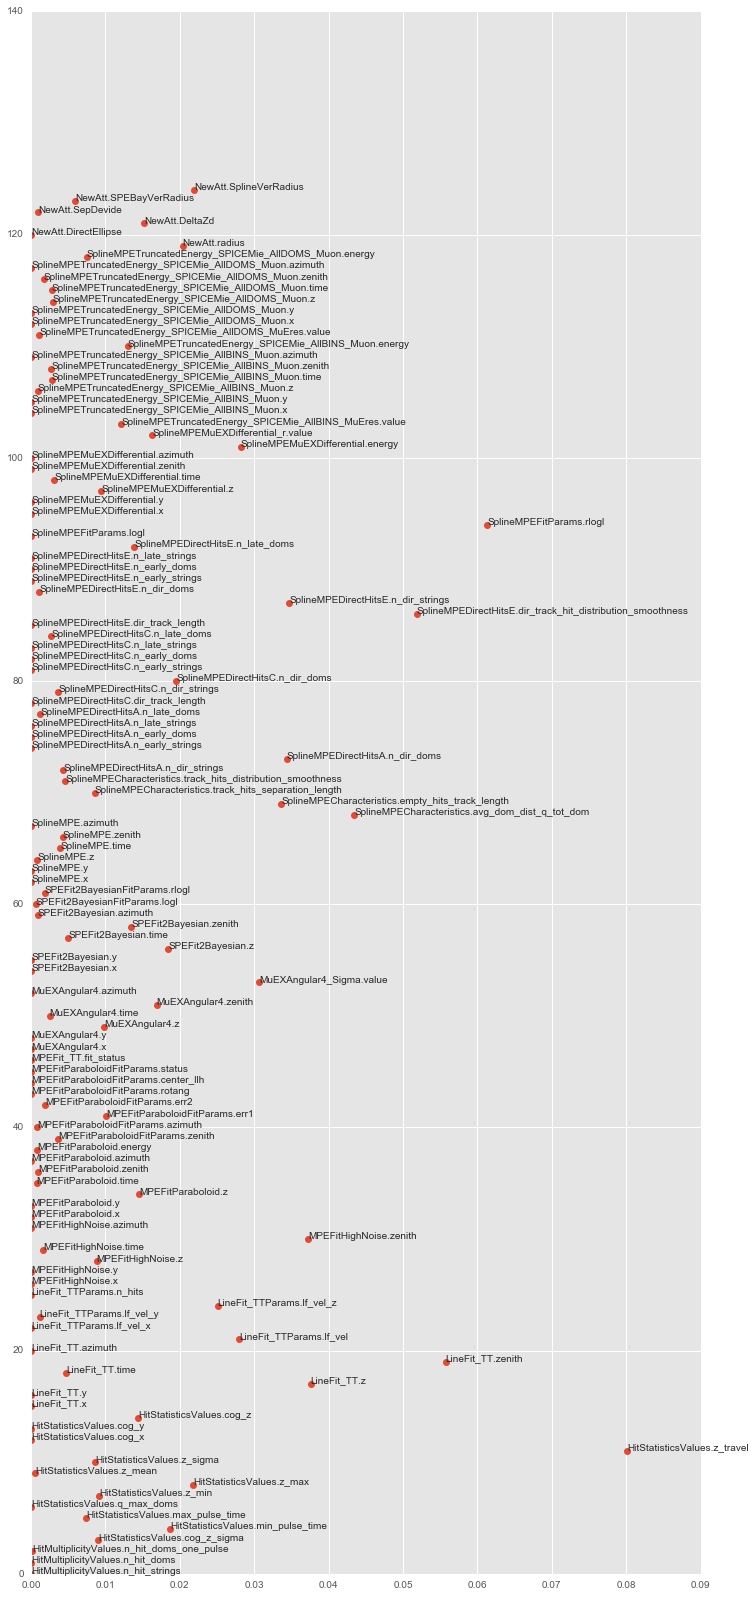

In [15]:
plt.figure(figsize=(12,28))
fis = gb.feature_importances_
plt.plot(fis, range(len(DATA.columns)), 'o')
for i, f in enumerate(DATA.columns):
    plt.annotate(f, (fis[i], i))
plt.show()